## This is the svm workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a linear support vector machine.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and includes code to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training an SVM classifier via gradient descent.

## Importing libraries and data setup

In [1]:
import numpy as np # for doing most of our calculations
import matplotlib.pyplot as plt# for plotting
from cs231n.data_utils import load_CIFAR10 # function to load the CIFAR-10 dataset.
import pdb

# Load matplotlib images inline
%matplotlib inline

# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Set the path to the CIFAR-10 data
cifar10_dir = r'C:\Users\lpott\Desktop\UCLA\ECENGR247C-80\HW2\cifar-10-batches-py'# You need to update this line
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


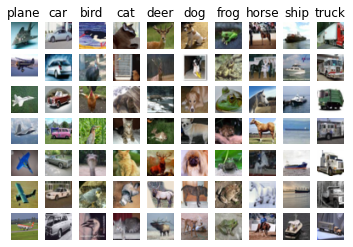

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
Dev data shape:  (500, 32, 32, 3)
Dev labels shape:  (500,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


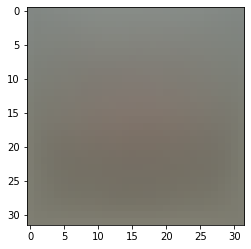

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Question:

(1) For the SVM, we perform mean-subtraction on the data.
However, for the KNN notebook, we did not.
Why?

## Answer:

(1) In KNN, performing mean-subtraction on the data does not change the distance between data points and therefore has no affect on the KNN model, whereas with SVM by performing mean-subtraction it is easier to learn the bias term, $b$, in the model parameterization $Wx + b$

## Training an SVM

The following cells will take you through building an SVM.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [9]:
from nndl.svm import SVM

In [10]:
# Declare an instance of the SVM class.  
# Weights are initialized to a random value.
# Note, to keep people's initial solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

svm = SVM(dims=[num_classes, num_features])

#### SVM loss

In [11]:
## Implement the loss function for in the SVM class(nndl/svm.py), svm.loss()

loss = svm.loss(X_train, y_train)
print('The training set loss is {}.'.format(loss))

# If you implemented the loss correctly, it should be 15569.98

The training set loss is 15569.977915410094.


#### SVM gradient

In [12]:
## Calculate the gradient of the SVM class.
# For convenience, we'll write one function that computes the loss
#   and gradient together. Please modify svm.loss_and_grad(X, y).
# You may copy and paste your loss code from svm.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = svm.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a numerical gradient check. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
svm.grad_check_sparse(X_dev, y_dev, grad)

numerical: -4.967782 analytic: -4.967782, relative error: 7.493931e-09
numerical: 3.503943 analytic: 3.503943, relative error: 3.705379e-08
numerical: -3.309230 analytic: -3.309229, relative error: 2.874579e-08
numerical: 9.755579 analytic: 9.755580, relative error: 3.428256e-08
numerical: 2.092639 analytic: 2.092639, relative error: 1.119547e-07
numerical: 1.663344 analytic: 1.663343, relative error: 2.153229e-07
numerical: 8.037637 analytic: 8.037637, relative error: 2.997896e-08
numerical: -9.176195 analytic: -9.176196, relative error: 1.420339e-08
numerical: 4.908887 analytic: 4.908887, relative error: 1.668948e-08
numerical: -9.926198 analytic: -9.926198, relative error: 3.458455e-09


## A vectorized version of SVM

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [13]:
import time

In [14]:
## Implement svm.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = svm.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = svm.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} / {}'.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output, i.e., differences on the order of 1e-12

Normal loss / grad_norm: 17029.25735786189 / 2346.5439182059426 computed in 0.05781102180480957s
Vectorized loss / grad: 17029.257357861898 / 2346.543918205942 computed in 0.001997709274291992s
difference in loss / grad: -7.275957614183426e-12 / 7.273601752569853e-12


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 16557.38000190916
iteration 100 / 1500: loss 4701.089451272714
iteration 200 / 1500: loss 4017.333137942788
iteration 300 / 1500: loss 3681.9226471953616
iteration 400 / 1500: loss 2732.616437398899
iteration 500 / 1500: loss 2786.6378424645054
iteration 600 / 1500: loss 2837.035784278267
iteration 700 / 1500: loss 2206.2348687399326
iteration 800 / 1500: loss 2269.03882411698
iteration 900 / 1500: loss 2543.237815385921
iteration 1000 / 1500: loss 2566.692135726827
iteration 1100 / 1500: loss 2182.068905905164
iteration 1200 / 1500: loss 1861.1182244250451
iteration 1300 / 1500: loss 1982.901385852826
iteration 1400 / 1500: loss 1927.5204158582117
That took 3.73305606842041s


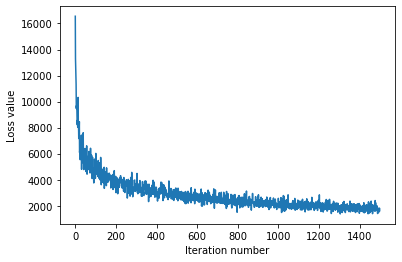

In [15]:
# Implement svm.train() by filling in the code to extract a batch of data
# and perform the gradient step.

tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=5e-4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained SVM on the validation data.

In [16]:
## Implement svm.predict() and use it to compute the training and testing error.

y_train_pred = svm.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = svm.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.28530612244897957
validation accuracy: 0.3


## Optimize the SVM

Note, to make things faster and simpler, we won't do k-fold cross-validation, but will only optimize the hyperparameters on the validation dataset (X_val, y_val).

In [17]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the SVM with different learning rates and evaluate on the
#     validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best VALIDATION accuracy corresponding to the best VALIDATION error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
#   Note: You do not need to modify SVM class for this section
# ================================================================ #
alphas = [5e-0,5e-1,5e-2,5e-3,5e-4,5e-5,5e-6,5e-7,5e-8,5e-9,5e-10]
#[1e-0,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10] 
best_acc = 0 #best_loss = 155690.977915410092 ; best_val = 0; best_alpha=alphas[0];
train_accs = []
val_accs = []
for alpha in alphas:
    tic = time.time()
    _ = svm.train(X_train, y_train, learning_rate=alpha,
                      num_iters=3000, batch_size=200,verbose=False)
    
    print("-"*50)
    print("Alpha={}\n".format(alpha))
    y_train_pred = svm.predict(X_train)
    train_acc = np.mean(np.equal(y_train,y_train_pred), )
    print('training accuracy: {}'.format(train_acc))
    y_val_pred = svm.predict(X_val)
    val_acc = np.mean(np.equal(y_val, y_val_pred))
    print('validation accuracy: {}'.format(val_acc, ))
    
    loss, _ = svm.fast_loss_and_grad(X_val, y_val)
    print('validation loss: {}'.format(loss))
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    if best_acc < val_acc:
        best_weight = np.copy(svm.W)
        best_loss = loss
        best_alpha = alpha
        best_acc = val_acc
    toc = time.time()
    
    print('That took {}s'.format(toc - tic))

print("-"*50)
print("-"*50)
print("The Learning Rate: {}\nThe best validation loss: {}\nThe best validation accuracy: {}\n".format(best_alpha,best_loss,best_acc))
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

--------------------------------------------------
Alpha=5.0

training accuracy: 0.2656122448979592
validation accuracy: 0.239
validation loss: 14927744.558534935
That took 7.611040830612183s
--------------------------------------------------
Alpha=0.5

training accuracy: 0.2674285714285714
validation accuracy: 0.261
validation loss: 1322964.5774036446
That took 7.801788806915283s
--------------------------------------------------
Alpha=0.05

training accuracy: 0.31083673469387757
validation accuracy: 0.306
validation loss: 81034.344573421
That took 7.854532241821289s
--------------------------------------------------
Alpha=0.005

training accuracy: 0.34420408163265304
validation accuracy: 0.338
validation loss: 8165.099349158859
That took 7.960841655731201s
--------------------------------------------------
Alpha=0.0005

training accuracy: 0.30489795918367346
validation accuracy: 0.318
validation loss: 1625.2208289339947
That took 8.000478506088257s
-----------------------------------

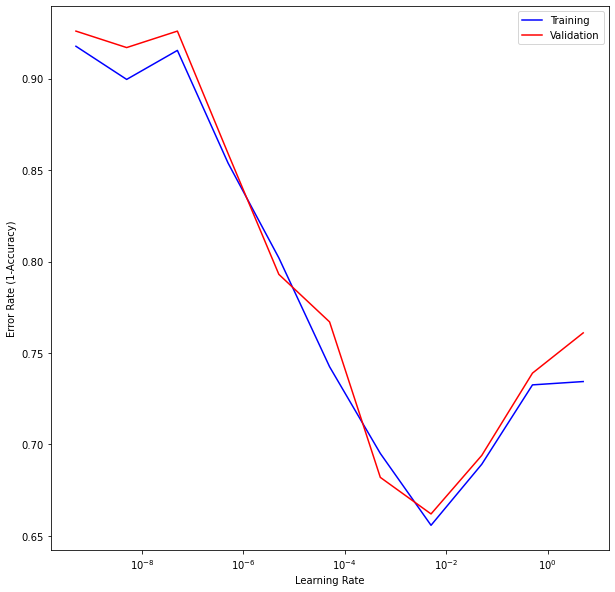

In [34]:
plt.figure(figsize=(10,10))
plt.plot(alphas,1-np.array(train_accs),'b-')
plt.plot(alphas,1-np.array(val_accs),'r-')
plt.xticks(alphas,alphas)
plt.semilogx()
plt.xlabel('Learning Rate')
plt.ylabel('Error Rate (1-Accuracy)')
plt.legend(['Training','Validation'])
plt.show()

In [18]:
svm.W = best_weight
y_val_test = svm.predict(X_test)
print('test accuracy: {}'.format(np.mean(np.equal(y_test, y_val_test)), ))

test accuracy: 0.325


## The best learning rate was 0.005, with the corresponding best test accuracy of 0.325, or error rate of 0.675

# svm.py functions

In [19]:
def loss(self, X, y):
    """
    Calculates the SVM loss.
  
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.
  
    Inputs:
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
  
    Returns a tuple of:
    - loss as single float
    """
  
    # compute the loss and the gradient
    num_classes = self.W.shape[0]
    num_train = X.shape[0]
    loss = 0.0

    for i in np.arange(num_train):
    # ================================================================ #
    # YOUR CODE HERE:
	  #   Calculate the normalized SVM loss, and store it as 'loss'.
    #   (That is, calculate the sum of the losses of all the training 
    #   set margins, and then normalize the loss by the number of 
	  #	  training examples.)
    # ================================================================ #
      score_i = np.dot(self.W,X[i,:].T)
      hinge_loss_i = np.clip(1+score_i-score_i[y[i]],a_min=0,a_max=float('inf'))
      hinge_loss_i[y[i]] = 0
      loss += 1/num_train*np.sum(hinge_loss_i)

      pass
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss

In [20]:
def loss_and_grad(self, X, y):
    """
	Same as self.loss(X, y), except that it also returns the gradient.

	Output: grad -- a matrix of the same dimensions as W containing 
		the gradient of the loss with respect to W.
	"""
  
    # compute the loss and the gradient
    num_classes = self.W.shape[0]
    num_train = X.shape[0]
    loss = 0.0
    grad = np.zeros_like(self.W)

    for i in np.arange(num_train):
    # ================================================================ #
    # YOUR CODE HERE:
	#   Calculate the SVM loss and the gradient.  Store the gradient in
    #   the variable grad.
    # ================================================================ #
      score_i = np.dot(self.W,X[i,:].T)
      hinge_loss_i = np.clip(1+score_i-score_i[y[i]],a_min=0,a_max=float('inf'))
      hinge_loss_i[y[i]] = 0
      loss += np.sum(hinge_loss_i)
    
      ai = ((1+score_i-score_i[y[i]]) > 0)[:,np.newaxis].astype(float)
      ai[y[i]] = -ai[y[i]]*(np.sum(ai)-1)
      grad += np.matmul(ai,X[i,:][np.newaxis,:])
      pass

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    loss /= num_train
    grad /= num_train

    return loss, grad


In [21]:
def fast_loss_and_grad(self, X, y):
    """
    A vectorized implementation of loss_and_grad. It shares the same
	inputs and ouptuts as loss_and_grad.
    """
    loss = 0.0
    grad = np.zeros(self.W.shape) # initialize the gradient as zero
  
    # ================================================================ #
    # YOUR CODE HERE:
	#   Calculate the SVM loss WITHOUT any for loops.
    # ================================================================ #
    scores = np.dot(self.W,X.T)
    
    
    hinge_loss = np.clip(1+scores-scores[y,np.arange(X.shape[0])],a_min=0,a_max=float('inf'))
    hinge_loss[y,np.arange(X.shape[0])] = 0
    loss = np.mean(np.sum(hinge_loss,0))
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #



	# ================================================================ #
    # YOUR CODE HERE:
	#   Calculate the SVM grad WITHOUT any for loops.
    # ================================================================ #
    a = (( 1 + scores - scores[y,np.arange(X.shape[0])] ) > 0).astype(float)
    a[y,np.arange(X.shape[0])] = -a[y,np.arange(X.shape[0])]*(np.sum(a,0)-1)
    tmp_grad = np.matmul(a,X)
    grad = grad + tmp_grad*1/ (X.shape[0])
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss, grad


In [22]:
def train(self, X, y, learning_rate=1e-3, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes

    self.init_weights(dims=[np.max(y) + 1, X.shape[1]])	# initializes the weights of self.W

    # Run stochastic gradient descent to optimize W
    loss_history = []

    for it in np.arange(num_iters):
      idx_batch = np.random.choice(num_train,batch_size)
      X_batch = X[idx_batch,:]
      y_batch = y[idx_batch]

      # ================================================================ #
      # YOUR CODE HERE:
      #   Sample batch_size elements from the training data for use in 
      #	  gradient descent.  After sampling,
      #     - X_batch should have shape: (dim, batch_size)
	    #     - y_batch should have shape: (batch_size,)
	    #   The indices should be randomly generated to reduce correlations
	    #   in the dataset.  Use np.random.choice.  It's okay to sample with
	    #   replacement.
      # ================================================================ #
      
      # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

      # evaluate loss and gradient
      loss, grad = self.fast_loss_and_grad(X_batch, y_batch)
      loss_history.append(loss)

      # ================================================================ #
      # YOUR CODE HERE:
      #   Update the parameters, self.W, with a gradient step 
      # ================================================================ #
      self.W = self.W - learning_rate * grad
	    # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

      if verbose and it % 100 == 0:
        print('iteration {} / {}: loss {}'.format(it, num_iters, loss))

    return loss_history

In [23]:
def predict(self, X):
    """
    Inputs:
    - X: N x D array of training data. Each row is a D-dimensional point.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[1])


    # ================================================================ #
    # YOUR CODE HERE:
    #   Predict the labels given the training data with the parameter self.W.
    # ================================================================ #
    scores = np.dot(self.W,X.T)
    y_pred = np.argmax(scores,axis=0)
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return y_pred